In [1]:
# Import library yang diperlukan
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mediapipe as mp
from scipy.spatial import distance
import os
import random
import matplotlib.pyplot as plt
import joblib

3. Load Gambar

Total frame yang diekstrak dari kantuk01.mp4: 15
Total frame yang diekstrak dari kantuk02-1.mp4: 59
Total frame yang diekstrak dari kantuk02.mp4: 77
Total frame yang diekstrak dari WIN_20241211_10_41_41_Pro.mp4: 58
Total frame yang diekstrak dari WIN_20241211_10_41_52_Pro.mp4: 23
Total frame yang diekstrak dari WIN_20241211_10_42_03_Pro.mp4: 37
Total frame yang diekstrak dari WIN_20241211_10_42_11_Pro.mp4: 65
Total frame yang diekstrak dari tidak_kantuk1.mp4: 239
Total frame yang diekstrak dari tidak_kantuk2.mp4: 241


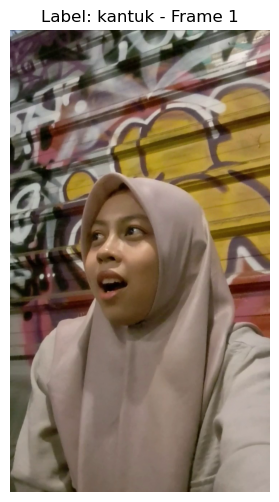

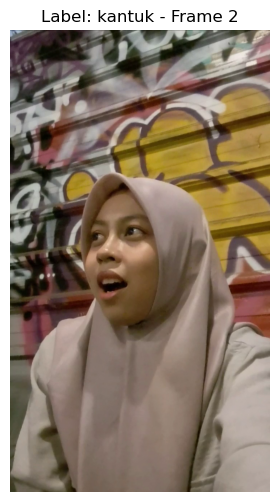

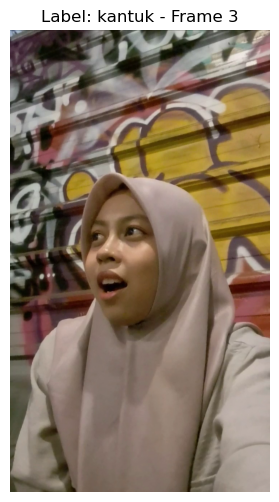

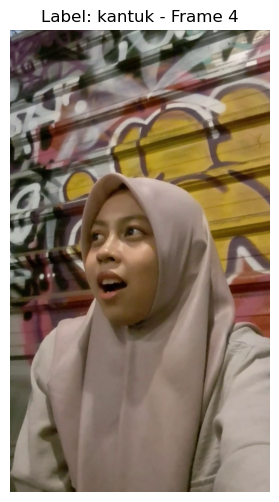

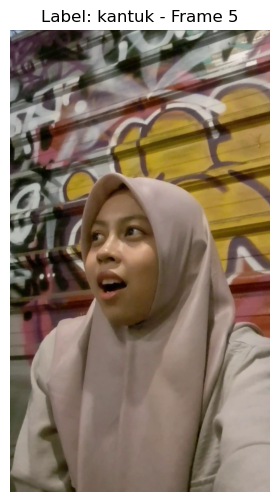

In [51]:
# Folder tempat video berada
video_folder_kantuk = 'Dataset/kantuk'
video_folder_non_kantuk = 'Dataset/tidak kantuk'

# Fungsi untuk membaca file video dalam folder tertentu
def get_video_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.mp4') or f.endswith('.avi')]

# Menggabungkan semua video dari kedua folder
video_files_kantuk = get_video_files(video_folder_kantuk)
video_files_non_kantuk = get_video_files(video_folder_non_kantuk)

# Fungsi untuk ekstrak frame dari video
def extract_frames(video_path, label):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Tidak dapat membuka video {video_path}.")
        return []

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:  # Hentikan jika video selesai
            break
        frames.append((frame, label))
    cap.release()
    return frames

# Ekstrak frame dari semua video dan tambahkan label
all_frames = []  # List untuk menyimpan frame dan label
for video_file in video_files_kantuk:
    frames = extract_frames(video_file, 'kantuk')
    all_frames.extend(frames)
    print(f"Total frame yang diekstrak dari {os.path.basename(video_file)}: {len(frames)}")

for video_file in video_files_non_kantuk:
    frames = extract_frames(video_file, 'tidak kantuk')
    all_frames.extend(frames)
    print(f"Total frame yang diekstrak dari {os.path.basename(video_file)}: {len(frames)}")

# Simpan frame dan label dalam list (daftar semua frame dari semua video)
all_extracted_frames = []  # List untuk menyimpan semua frame dan label
for frame, label in all_frames:
    all_extracted_frames.append((frame, label))

# Tampilkan 5 frame dari setiap video
for i, (frame, label) in enumerate(all_extracted_frames[:5]):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(frame_rgb)
    plt.title(f"Label: {label} - Frame {i + 1}")
    plt.axis('off')
    plt.show()

In [52]:
print(f"{len(all_extracted_frames)}")

814


### 4.1. Pre-processing: BGR ke Grayscale, HOG Face Detector,

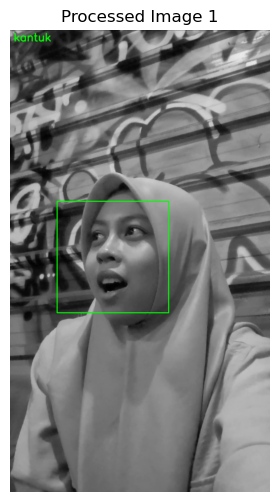

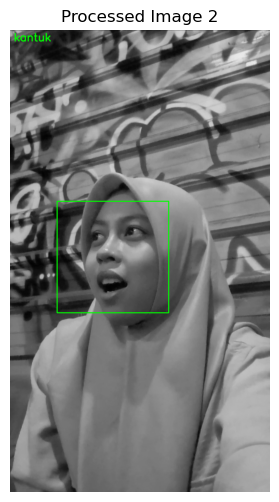

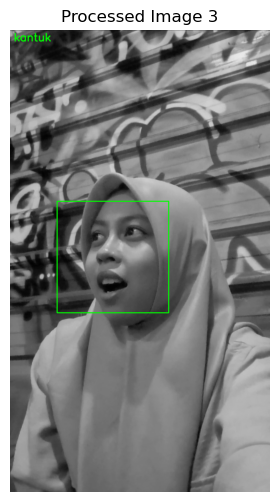

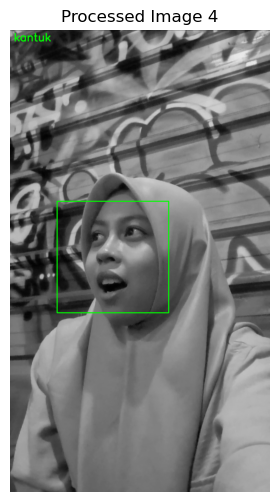

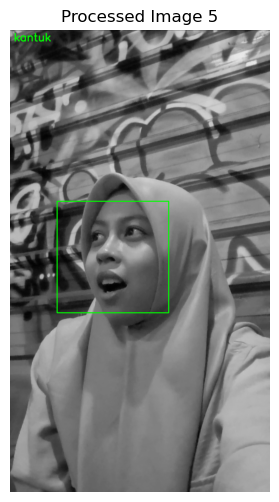

In [53]:
import cv2
import matplotlib.pyplot as plt
import dlib

# Inisialisasi detektor wajah HOG
hog_face_detector = dlib.get_frontal_face_detector()

# Fungsi untuk memproses frame dan deteksi wajah
def process_frames(all_extracted_frames, detector):
    processed_images = []  # List untuk menyimpan gambar yang diproses
    for frame, label in all_extracted_frames:
        # Konversi frame ke grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Deteksi wajah menggunakan HOG
        faces = detector(gray)

        # Tambahkan kotak hijau di sekitar wajah
        image_with_faces = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        for face in faces:
            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
            cv2.rectangle(image_with_faces, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Tambahkan label ke gambar
        cv2.putText(image_with_faces, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Tambahkan gambar yang sudah diproses ke dalam list
        processed_images.append(image_with_faces)

    return processed_images  # Mengembalikan list gambar yang sudah diproses


# Contoh list all_extracted_frames yang berisi frame dari video
# all_extracted_frames = [(frame1, 'kantuk'), (frame2, 'tidak kantuk'), ...]

# Proses semua frame dalam list all_extracted_frames
processed_images = process_frames(all_extracted_frames, hog_face_detector)

# Tampilkan hasil pemrosesan (opsional)
for i, img in enumerate(processed_images[:5]):  # Batasi tampilan maksimal 5 gambar
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Processed Image {i + 1}')
    plt.axis('off')
    plt.show()

In [54]:
print(f"{len(processed_images)}")

814


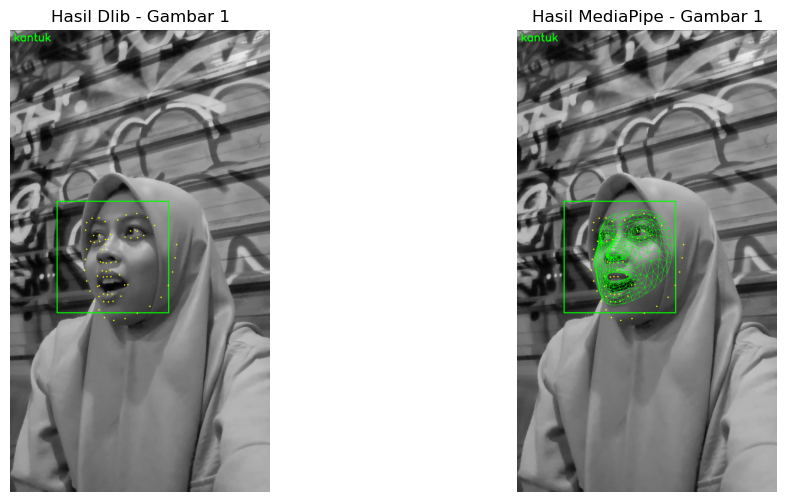

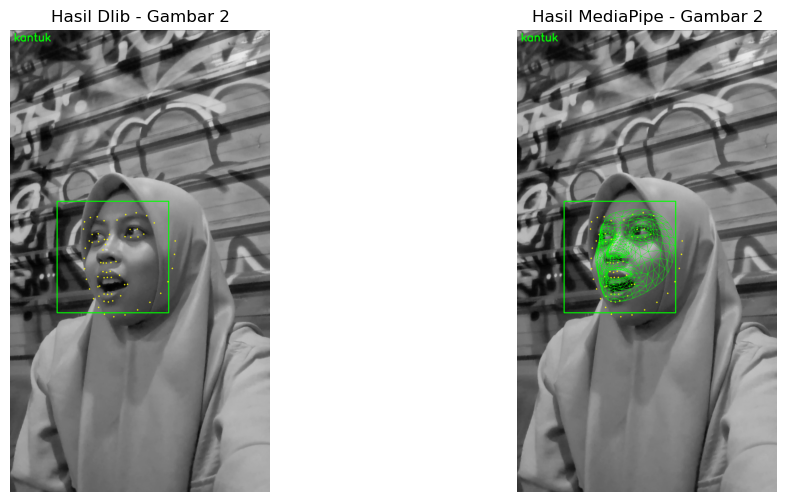

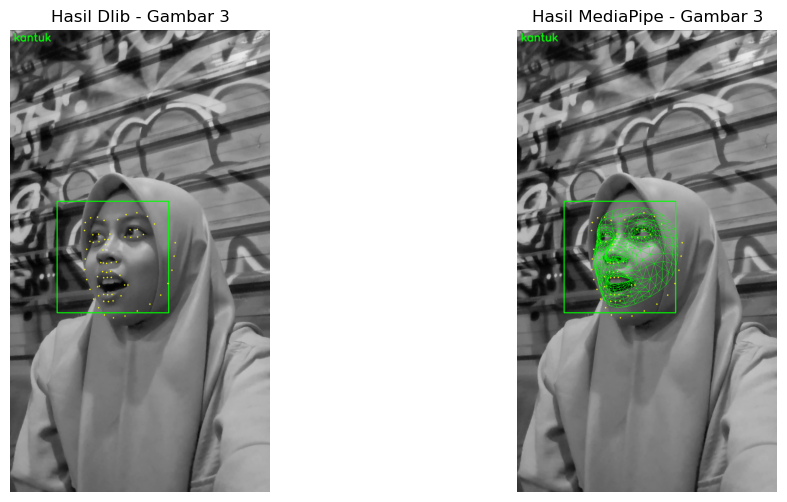

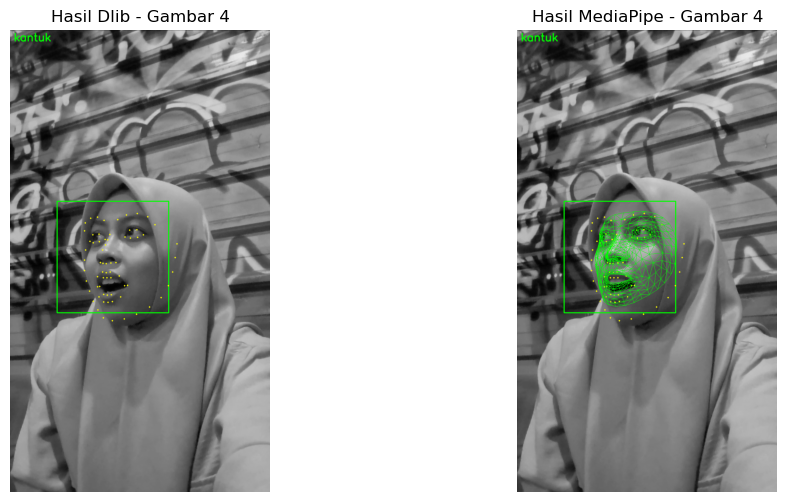

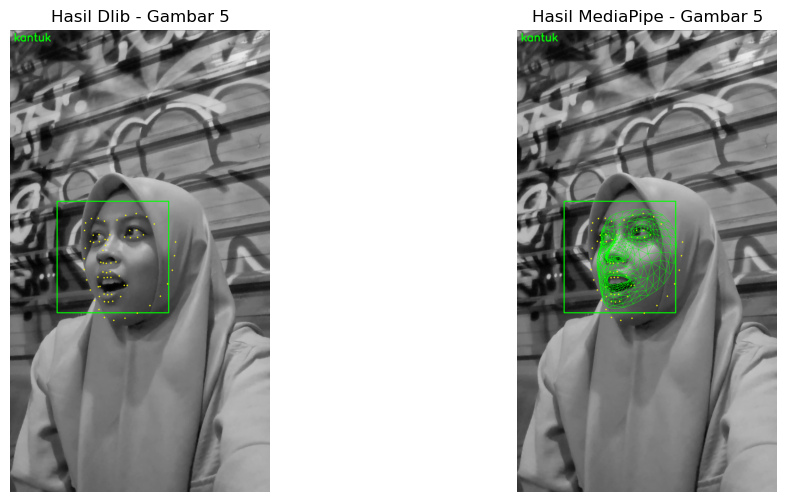

In [55]:
import cv2
import matplotlib.pyplot as plt
import dlib
import mediapipe as mp

# Memuat model Dlib untuk landmark wajah
predictor_path = 'shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)
hog_face_detector = dlib.get_frontal_face_detector()  # Inisialisasi HOG face detector

# Inisialisasi MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5
)

# List untuk menyimpan hasil deteksi Dlib
dlib_processed_images = []
# List untuk menyimpan hasil deteksi MediaPipe
mediapipe_processed_images = []

# Proses setiap gambar dalam processed_images
for image in processed_images:  # Menggunakan gambar yang telah diproses sebelumnya
    # Konversi gambar ke grayscale untuk deteksi wajah dengan Dlib
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah dengan Dlib
    faces = hog_face_detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(0, 68):  # Mengambil 68 titik landmark wajah
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 2, (0, 255, 255), -1)  # Menandai titik landmark dengan warna kuning

    # Simpan gambar yang telah diproses oleh Dlib ke dalam list
    dlib_processed_images.append(image)

# Proses gambar-gambar yang telah diproses oleh Dlib dengan MediaPipe
for idx, image in enumerate(dlib_processed_images):
    # Gambar yang telah diproses Dlib digunakan sebagai input untuk MediaPipe
    image_mesh = image.copy()

    # Proses dengan Face Mesh dari MediaPipe
    results = face_mesh.process(cv2.cvtColor(image_mesh, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image_mesh,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
            )

    # Simpan gambar hasil deteksi MediaPipe ke dalam list mediapipe_processed_images
    mediapipe_processed_images.append(image_mesh)

for i, (dlib_image, mediapipe_image) in enumerate(zip(dlib_processed_images[:5], mediapipe_processed_images[:5])):
    plt.figure(figsize=(12, 6))

    # Plot hasil Dlib
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(dlib_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Hasil Dlib - Gambar {i + 1}')
    plt.axis('off')

    # Plot hasil MediaPipe
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(mediapipe_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Hasil MediaPipe - Gambar {i + 1}')
    plt.axis('off')

    plt.show()

In [56]:
print(f"{len(dlib_processed_images)}")

814


In [57]:
print(f"{len(mediapipe_processed_images)}")

814


In [63]:
%pip install mediapipe

# Ekstraksi Fitur

In [58]:
import numpy as np
from scipy.spatial import distance

# Fungsi untuk menghitung Eye Aspect Ratio (EAR)
def calculate_ear(landmarks):
    # Menghitung jarak antara titik-titik pada mata
    # Mata Kiri
    A1 = distance.euclidean(np.array(landmarks[37]), np.array(landmarks[41]))  # Vertikal
    B1 = distance.euclidean(np.array(landmarks[38]), np.array(landmarks[40]))  # Vertikal
    C1 = distance.euclidean(np.array(landmarks[36]), np.array(landmarks[39]))  # Horizontal

    # Mata Kanan
    A2 = distance.euclidean(np.array(landmarks[43]), np.array(landmarks[47]))  # Vertikal
    B2 = distance.euclidean(np.array(landmarks[44]), np.array(landmarks[46]))  # Vertikal
    C2 = distance.euclidean(np.array(landmarks[42]), np.array(landmarks[45]))  # Horizontal

    # Menghitung EAR untuk kedua mata dan rata-ratanya
    ear_left = (B1 + C1) / (2.0 * A1)
    ear_right = (B2 + C2) / (2.0 * A2)

    ear = (ear_left + ear_right) / 2.0
    return ear

# Fungsi untuk menghitung Mouth Aspect Ratio (MAR)
def calculate_mar(landmarks):
    # Menghitung jarak antara titik-titik pada mulut
    A = distance.euclidean(np.array(landmarks[62]), np.array(landmarks[66]))  # Jarak vertikal
    B = distance.euclidean(np.array(landmarks[61]), np.array(landmarks[67]))  # Jarak horizontal
    C = distance.euclidean(np.array(landmarks[60]), np.array(landmarks[64]))  # Jarak horizontal
    D = distance.euclidean(np.array(landmarks[59]), np.array(landmarks[63]))  # Jarak horizontal

    # Menghitung MAR menggunakan formula
    mar = (B + C + D) / (2.0 * A)
    return mar

In [59]:
from sklearn.preprocessing import LabelEncoder

# Buat instance LabelEncoder
label_encoder = LabelEncoder()

# Daftar label (misalnya) yang berisi 'kantuk' dan 'tidak kantuk'
labels = [label for _, label in all_extracted_frames]  # Misalnya list label dari 'all_extracted_frames'

# Terapkan LabelEncoder untuk mengubah label menjadi angka (1 untuk kantuk, 0 untuk tidak kantuk)
encoded_labels = label_encoder.fit_transform(labels)

# Menampilkan hasil encoding
print("Label asli:", labels)
print("Label setelah encoding:", encoded_labels)


Label asli: ['kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk', 'kantuk

In [60]:
# Hasil encoding untuk setiap label
encoded_labels = label_encoder.fit_transform([label for _, label in all_extracted_frames])

# Menyimpan hasil di dalam results
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, (image, label) in enumerate(zip(mediapipe_processed_images, all_extracted_frames)):  
    # Konversi label ke dalam format numerik (0 atau 1)
    label_encoded = encoded_labels[idx]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR dan MAR ke list
        ear_values.append(ear)
        mar_values.append(mar)

        # Ekstrak koordinat x dan y untuk landmark hidung (landmark 30)
        nose_x = landmarks.part(30).x
        nose_y = landmarks.part(30).y

        # Tambahkan koordinat ke list
        nose_x_coords.append(nose_x)
        nose_y_coords.append(nose_y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "Label": label_encoded,  # Simpan label yang sudah di-encode
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords,
    })

# Cetak hasil per gambar
for result in results:
    print(f"Gambar {result['Gambar']} - Label: {result['Label']}:")
    print("  Eye Aspect Ratios:", result["EAR"])
    print("  Mouth Aspect Ratios:", result["MAR"])
    print("  Nose X Coordinates:", result["Nose X"])
    print("  Nose Y Coordinates:", result["Nose Y"])


C:\Users\Axioo Pongo\AppData\Local\Temp\ipykernel_29468\3515431958.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mar = (B + C + D) / (2.0 * A)


Gambar 1 - Label: 0:
  Eye Aspect Ratios: [1.6122022603256454]
  Mouth Aspect Ratios: [2.609197048961495]
  Nose X Coordinates: [270]
  Nose Y Coordinates: [616]
Gambar 2 - Label: 0:
  Eye Aspect Ratios: []
  Mouth Aspect Ratios: []
  Nose X Coordinates: []
  Nose Y Coordinates: []
Gambar 3 - Label: 0:
  Eye Aspect Ratios: []
  Mouth Aspect Ratios: []
  Nose X Coordinates: []
  Nose Y Coordinates: []
Gambar 4 - Label: 0:
  Eye Aspect Ratios: []
  Mouth Aspect Ratios: []
  Nose X Coordinates: []
  Nose Y Coordinates: []
Gambar 5 - Label: 0:
  Eye Aspect Ratios: []
  Mouth Aspect Ratios: []
  Nose X Coordinates: []
  Nose Y Coordinates: []
Gambar 6 - Label: 0:
  Eye Aspect Ratios: []
  Mouth Aspect Ratios: []
  Nose X Coordinates: []
  Nose Y Coordinates: []
Gambar 7 - Label: 0:
  Eye Aspect Ratios: [1.788067398455895]
  Mouth Aspect Ratios: [2.3416750613866997]
  Nose X Coordinates: [255]
  Nose Y Coordinates: [625]
Gambar 8 - Label: 0:
  Eye Aspect Ratios: []
  Mouth Aspect Ratios: []


In [61]:
import pandas as pd

# Simpan hasil ke file CSV
df = pd.DataFrame(results)
df.to_csv('hasil_ekstraksi_fitur.csv', index=False)
print("Hasil deteksi berhasil disimpan ke file 'hasil_ekstraksi_fitur.csv'")

Hasil deteksi berhasil disimpan ke file 'hasil_ekstraksi_fitur.csv'


In [61]:
import csv

# Menyiapkan data yang akan disimpan dalam CSV
csv_data = []

# Proses setiap gambar dari list hasil MediaPipe
for result in results:
    gambar = result['Gambar']
    label = result['Label']
    ear_values = result["EAR"]
    mar_values = result["MAR"]
    nose_x_coords = result["Nose X"]
    nose_y_coords = result["Nose Y"]

    # Menyimpan nilai pertama (atau pilih nilai lain sesuai keinginan)
    first_ear = ear_values[0] if ear_values else None
    first_mar = mar_values[0] if mar_values else None
    first_nose_x = nose_x_coords[0] if nose_x_coords else None
    first_nose_y = nose_y_coords[0] if nose_y_coords else None

    # Tambahkan data ke list csv_data
    csv_data.append([gambar, label, first_ear, first_mar, first_nose_x, first_nose_y])

# Menyimpan data ke dalam CSV
csv_file = "output.csv"
header = ["Gambar", "Label", "EAR", "MAR", "Nose X", "Nose Y"]

# Menulis data ke CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Menulis header
    writer.writerows(csv_data)  # Menulis data

print(f"Data berhasil disimpan dalam {csv_file}")


Data berhasil disimpan dalam output.csv


# Model Random Forest

Memuat dan Menyiapkan data

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import joblib
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import numpy as np

In [62]:
import pandas as pd

# Membaca data dari file CSV
df = pd.read_csv('output.csv')

# Memisahkan fitur dan label
X = df[['EAR', 'MAR', 'Nose X', 'Nose Y']]  # Fitur
y = df['Label']  # Label

In [63]:
df.head()

,Gambar,Label,EAR,MAR,Nose X,Nose Y
0,1,0,1.612202,2.609197,270,616
1,7,0,1.788067,2.341675,255,625
2,10,0,1.832705,2.967837,257,616
3,11,0,1.501997,2.369128,253,610
4,12,0,1.733911,2.123039,256,622


Split Data

In [64]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi data latih dan data uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
def add_noise(data, noise_level=0.01):
    noisy_data = data.copy()
    for col in data.columns:
        if data[col].dtype != 'object':  # Hanya untuk fitur numerik
            noise = np.random.normal(0, noise_level * data[col].std(), size=data[col].shape)
            noisy_data[col] += noise
    return noisy_data

X_train_noisy = add_noise(X_train, noise_level=0.05)

In [66]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train_noisy_imputed = imputer.fit_transform(X_train_noisy)

In [67]:
from imblearn.over_sampling import SMOTE

# Oversampling menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_noisy_imputed, y_train)


In [68]:
import numpy as np

# Mengecek apakah ada nilai NaN atau inf di X_test
print("Ada nilai NaN di X_test?", np.any(np.isnan(X_test)))
print("Ada nilai inf di X_test?", np.any(np.isinf(X_test)))

# Menangani nilai NaN atau inf dengan mengganti dengan 0 atau nilai lain
X_test = X_test.replace([np.inf, -np.inf], np.nan)  # Ganti inf dengan NaN


Ada nilai NaN di X_test? False
Ada nilai inf di X_test? False


In [69]:
# Terapkan imputasi pada X_test setelah menangani NaN dan inf
X_test_imputed = imputer.transform(X_test)

# Cek apakah imputasi berhasil
print("Apakah ada NaN di X_test setelah imputasi?", np.any(np.isnan(X_test_imputed)))


Apakah ada NaN di X_test setelah imputasi? False


Latih Model

In [70]:
# 3. Melatih model dengan data yang sudah diaugmentasi
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Model dengan parameter untuk mengurangi overfitting
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Latih model
model.fit(X_train_smote, y_train_smote)

# Terapkan imputasi pada X_test
X_test_imputed = imputer.transform(X_test)


In [71]:
# Evaluasi pada data latih
y_pred_train = model.predict(X_train_smote)
print("Evaluasi pada Data Latih:")
print(f"Akurasi: {accuracy_score(y_train_smote, y_pred_train)}")
print(classification_report(y_train_smote, y_pred_train))

# Evaluasi pada data uji
y_pred_test = model.predict(X_test_imputed)
print("\nEvaluasi pada Data Uji:")
print(f"Akurasi: {accuracy_score(y_test, y_pred_test)}")
print(classification_report(y_test, y_pred_test))

Evaluasi pada Data Latih:
Akurasi: 0.9959514170040485
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      1.00      1.00       247

    accuracy                           1.00       494
   macro avg       1.00      1.00      1.00       494
weighted avg       1.00      1.00      1.00       494


Evaluasi pada Data Uji:
Akurasi: 0.9829059829059829
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        70
           1       0.98      0.98      0.98        47

    accuracy                           0.98       117
   macro avg       0.98      0.98      0.98       117
weighted avg       0.98      0.98      0.98       117



Simpan Model

In [72]:
import joblib

# Simpan model ke file
joblib.dump(model, 'model_random_forest.pkl')
print("Model berhasil disimpan ke file 'model_random_forest.pkl'")

Model berhasil disimpan ke file 'model_random_forest.pkl'


In [91]:
print(model)  # Jika model sudah didefinisikan, outputnya akan menampilkan informasi model

RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       n_jobs=-1, random_state=42)


In [2]:
import cv2
import dlib
import numpy as np

# Memuat detektor wajah dan prediktor landmark
hog_face_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat')

# Fungsi untuk menghitung EAR dan MAR
def calculate_ear(landmarks):
    # Hitung EAR
    A1 = np.linalg.norm(np.array(landmarks[37]) - np.array(landmarks[41]))  # Vertikal
    B1 = np.linalg.norm(np.array(landmarks[38]) - np.array(landmarks[40]))  # Vertikal
    C1 = np.linalg.norm(np.array(landmarks[36]) - np.array(landmarks[39]))  # Horizontal
    
    A2 = np.linalg.norm(np.array(landmarks[43]) - np.array(landmarks[47]))  # Vertikal
    B2 = np.linalg.norm(np.array(landmarks[44]) - np.array(landmarks[46]))  # Vertikal
    C2 = np.linalg.norm(np.array(landmarks[42]) - np.array(landmarks[45]))  # Horizontal

    ear_left = (B1 + C1) / (2.0 * A1)
    ear_right = (B2 + C2) / (2.0 * A2)

    return (ear_left + ear_right) / 2.0

def calculate_mar(landmarks):
    # Hitung MAR
    A = np.linalg.norm(np.array(landmarks[62]) - np.array(landmarks[66]))  # Vertikal
    B = np.linalg.norm(np.array(landmarks[61]) - np.array(landmarks[67]))  # Horizontal
    C = np.linalg.norm(np.array(landmarks[60]) - np.array(landmarks[64]))  # Horizontal
    D = np.linalg.norm(np.array(landmarks[59]) - np.array(landmarks[63]))  # Horizontal

    return (B + C + D) / (2.0 * A)

# Fungsi untuk mengekstrak fitur dari gambar (hanya EAR, MAR, dan Nose X)
def extract_features_from_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = hog_face_detector(gray)
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:
        landmarks = predictor(gray, face)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        ear_values.append(ear)
        mar_values.append(mar)
        nose_x_coords.append(landmarks.part(30).x)  # Hanya menggunakan Nose X
        nose_y_coords.append(landmarks.part(31).y)  

    # Mengembalikan fitur yang diekstrak (3 fitur)
    return [np.mean(ear_values), np.mean(mar_values), np.mean(nose_x_coords), np.mean(nose_y_coords)]

# Memuat gambar
image_path = 'test/CAP7426594241795776609.jpg'  # Ganti dengan path gambar Anda
image = cv2.imread(image_path)

# Mengekstrak fitur dari gambar
features = extract_features_from_image(image)
print(features)  # Cek hasil ekstraksi fitur


[nan, nan, nan, nan]


c:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [52]:
# Membaca model yang telah dilatih (pastikan model sudah disimpan)
model = joblib.load('model_random_forest.pkl')  # Ganti dengan path model Anda

# Melakukan prediksi dengan model
prediction = model.predict([features])  # Fitur yang sudah diekstrak dalam bentuk array 2D
print("Prediksi:", prediction)

# Menampilkan hasil prediksi (misalnya 0 = kantuk, 1 = tidak kantuk)
if prediction == 0:
    print("Pengemudi dalam kondisi kantuk!")
else:
    print("Pengemudi dalam kondisi tidak kantuk!")


Prediksi: [0]
Pengemudi dalam kondisi kantuk!


In [99]:
# Menyimpan imputer yang sudah di-fit
joblib.dump(imputer, 'imputer.pkl')

['imputer.pkl']